In [1]:
import os
import pandas as pd
import pm4py
import numbers
import decimal
import pandas.api.types as ptypes
import numpy as np
from pm4py.algo.filtering.log.cases import case_filter
from pm4py.algo.filtering.pandas.timestamp import timestamp_filter
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from pm4py.algo.filtering.pandas.variants import variants_filter
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.util import constants
from pm4py.statistics.traces.pandas import case_statistics
from pm4py.algo.filtering.log.attributes import attributes_filter
from numpy.linalg import norm
from pm4py.objects.log.importer.xes import importer as xes_importer
from multiprocessing import Process, Queue, Pool, cpu_count
import multiprocessing
import random
import itertools
import functools
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist, pdist
from scipy.spatial import distance
import math
import time
import matplotlib.pyplot as plt

In [2]:
#this function modifies all the case id column value s.t. every case id look like
#Case 1637838
#Case 6869797
#.
#.
#.

def rename_caseid(x):
    
    x = str(x)
    
    if 'Case' in x:
        
        if x.startswith('Case') == False:
            
            #remove the word "Case" from x
            x = x.replace("Case", "")
            x = x.replace("case", "")
            
            #remove all the whitespace from x "".join(x.split())
            x = "".join(x.split())
            
            #remove all the slash from the x 
            x = x.replace("\\", "")
            x = x.replace("/", "")
        
        else :
            
            pass
            
    else :
        
        x = str("Case ") + str(x) 
    
    return str(x)

def abs_numcols(x):
    
    return abs(x)

#how to use this function:
#1. grab the column name of the case id(in this example, it is CustomerID)
#2. assing the applied column to the original column like below
#Example : cops["CustomerID"] = cops["CustomerID"].apply(rename_caseid)

def preprocessing_caseid(df, case_column):
    
    df[case_column] = df[case_column].apply(rename_caseid)
    
    return df

In [11]:



#convert log file(in csv) to pandas dataframe

"""
QUESTIONS!
importing scheme

1.the major attributes : Case ID, Activity, Complete Timestamp, and org(resource or something)
They should be ordered such that the rest can be considered as case attributes
!!!!!!!this should be done either for xes or csv, also how to parse the given event log file such that
they can be managed in the form Case ID, Acitivity, Timestamp, and resource? is there any scheme to detect which colume
corresponds to which attribute?

2.importing method should deliver also the file path such that this program
can choose either xes or csv file converting

3. what is an empty value exists?

4. organize log file such that
caseid should be the first column
the others resource, timestamp

#It could make the whole process easy
5. allow user to select/organize columns by checking the name
??

Weakness:

1. still depending on the column orders
2. to often used the Case ID
3. def export_file(df, caseids, s_vci, n = 1): find the scheme s.t. 
n indicates unique selection, logarithmic, and division selection

"""

#read the csv file
log_csv = pd.read_csv('../eventlogs/roadtraffic100traces.csv', sep=',')
#fill the csv file with the most frequent values of each column
log_csv = log_csv.fillna(log_csv.mode().iloc[0])
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'case:concept:name', 
    constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'concept:name', 
            constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"
           }
#event_log = log_converter.apply(log_csv,parameters=param_keys)


#import xes file
#q = xes_importer.apply('../eventlogs/repairExample.xes')

#convert xes to dataframe
#dataframe = log_converter.apply(q, variant=log_converter.Variants.TO_DATA_FRAME)

#ci is necessary for access the original case id of log file
#this should be differ from the "Case IDs" which contains the list of case ids
ci = 'case:concept:name'
ac = 'concept:name'

#this method will preprocess the given log_csv
#it means it will organize the dataframe such that
"""
            Case ID
variant
abc         ["Case 1", "Case 23", ...]
acc         ["Case 10", "Case 22", ...]
adc         ["Case 5", "Case 6", ...]
.
.
.
.
.
.

"""
#log_csv
#mys.isnull().all()
#df.columns[df.isna().any()].tolist()

"""
Idea
drop columns thatsdfsd
contains nan
and # unique value =< 2
the others fill na with the most frequent value
"""
#df.name.mode() ECMO

'\nIdea\ndrop columns thatsdfsd\ncontains nan\nand # unique value =< 2\nthe others fill na with the most frequent value\n'

In [3]:
def fill_mode(df):
    
    df = df.fillna(df.mode().iloc[0])
    
    return df

def preprocessing_caseid_nan(df, col_name):
    
    droppings = df.columns[df.isna().any()].tolist()
    fillnas = []
    
    for d in droppings:
        
        if len(list(df[d].unique())) > 2:
            
            droppings.remove(d)

        else :
            
            pass
    
    df = df.drop(droppings, axis=1)
    
    df[col_name] = df[col_name].apply(rename_caseid)
    df = df.apply(lambda col:fill_mode(col))
    
    return df

## 1-Traversing the event log:

In [4]:

def preprocessing_csv(log_csv, caseid, activity):
    
    #organize the variant for each case
    #this csv has the index as the Case ID and the value variant
    variants = case_statistics.get_variants_df(log_csv,
                                          parameters={constants.PARAMETER_CONSTANT_CASEID_KEY: caseid,
                                                      constants.PARAMETER_CONSTANT_ACTIVITY_KEY: activity})
    
    
    variant_caseid = variants.copy()
    
    #a. duplicate the case ids as an additional column
    variant_caseid['Case IDs'] = variants.index
    
    #b. set variant(sequence of acitvities) as the index
    #-> exchange the index from case id to variant
    # duplicated Case Ids contain the case Ids, the case Ids in the index is deleted
    variant_caseid.set_index('variant', inplace=True)
    
    #c. duplicate variant and store them as an additional column
    variant_caseid['variant2'] = variant_caseid.index
    
    #d copy the dataframe
    variant_caseid_statistics = variant_caseid.copy()
    
    #e dataframe that contains collected list of case ids
    variant_caseid_statistics = variant_caseid.groupby("variant2")["Case IDs"].apply(list).to_frame()
    
    #f. add to variant_caseid_statistics the length of each list Case IDs
    variant_caseid_statistics["casenums"] = variant_caseid_statistics["Case IDs"].str.len()
    # reset index -> assign numbers to each variant
    #variant_caseid_statistics = variant_caseid_statistics.reset_index(drop=True)
    
    #g. collect every case ids sharing the same variant
    variant_caseid = list(variant_caseid.groupby("variant2")["Case IDs"].apply(list))
    
    #h. vizualize the statistics
    #variant_caseid_statistics.plot(y = "casenums",  kind="bar", rot=5, fontsize=7, use_index=True, figsize=(50,10))
    
    #variant_caseid contains all the list of case ids sharing the same variant
    #statistics is the organized dataframe to represent the statistics
    return variant_caseid, variant_caseid_statistics
    

## 2-Distribution Computation:

In [5]:
############################################################################################################
############################################################################################################
#############################################ATTENTION!!!!!!################################################
############################################################################################################
#############################################################################################################
"""
the [1:4 means just the unnecessary columns like unnecessary data 
time, or something
in this case, it is the second, third, and fourth column

unnecessaries=["concept:name",
               "dismissal",
               "expense",
               "lastSent",
               "lifecycle:transition",
               "notificationType",
               "org:resource",
               "paymentAmount",
               "points",
               "time:timestamp"]
"""


#df.drop(columns, inplace=True, axis=1)
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def get_last_activities(logdf, ci, unnecessaries = []):
    
    #copy the dataframe
    log_csv2 = logdf.copy()
    
    #just keep the last activity record
    last_activities = log_csv2.drop_duplicates(subset=[str(ci)], keep = "last")
    
    #drop unnecessary columns such as timestamp and resource
    #1:4 means determined index that are not necessary
    #intersection(lst1, lst2)
    unnecessaries = intersection(unnecessaries, list(logdf.columns))
    last_activities = last_activities.drop(unnecessaries, axis = 1)
    
    return last_activities

#this function splits the given list a in n parts
#such that splitted sublists have roughly same length
#be used : a : caseids, n : # processes = 4 -> split the list of caseids
def split(a, n):
    
    #the function divmod takes two argument (a1, a2) and returns two results(r1, r2)
    #r1 = a1/a2, r2 = a1 mod a2
    """
    divmod(8, 3) =  (2, 2)
    divmod(7.5, 2.5) =  (3.0, 0.0)
    """
    k, m = divmod(len(a), n)
    return list((a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n)))

#filtersingles filter out all the variant with just 1 cases
#be used : l -> list of caseids
def filtersingles(l):
    
    #variants with just one case
    singles = [i for i in l if len(i) == 1]
            
    #the left outcome is the list of case ids that share the variant
    # in other words, the collection of case ids of each variant
    return [x for x in l if x not in singles], singles

#this function uses multiprocessing to apply parallel programming paradigm 
def filtersingles_mp(a_list):
    
    #multiprocessing with 4 processes
    PROCESSES = 4
    
    #starting multiprocessing
    with multiprocessing.Pool(PROCESSES) as pool:
    
        chunks = split(list(a_list), 4)
    
        results = [pool.apply_async(filtersingles, [chunk]) for chunk in chunks]
        
        #list comprehension is mostly used because it is a bit faster than
        #the same functionality of a single loop
        nonsingles = [r.get()[0] for r in results]
        singles = [r.get()[1] for r in results]
            
    return nonsingles, singles


def modifyindex(df, ci):
    
    df = df.set_index(ci)
    
    return df

In [6]:
def filter_catcols(logdf, ci):
    
    #returns the categorical column index of each column
    ccols = [c for c in range(len(list(logdf.columns))) if ptypes.is_numeric_dtype(logdf[list(logdf.columns)[c]]) != True]
    
    print(list(logdf.columns))
    
    caseid_index = logdf.columns.get_loc(str(ci))
    #.columns.get_loc("case:concept:name")
    
    if isinstance(ccols, list):
        
        if len(ccols) >= 1:
    
            if caseid_index in ccols:
            
                ccols.remove(caseid_index)
    
    return ccols

#multiply 1 to whole column such that they can be numeric
def preprocessig_df(logdf, ci):
    
    result_df = logdf.copy()
    
    for c in range(len(list(result_df.columns))):
        
        #check if the column is boolean
        if ptypes.is_bool_dtype(list(result_df.columns)[c]) == True:
            
            #then multiply 1 to whole column such that they can be numeric
            #used if else such that each column can be checked with on condition 
            result_df.iloc[:, c].apply(lambda x: x*1)
        
        #check if the column is numeric
        elif ptypes.is_numeric_dtype(list(result_df.columns)[c]) == True:
            
            #if yes, convert it to the absolute value
            result_df.iloc[:, c].apply(abs_numcols)
                
        else :
            
            pass
            
    ccols = filter_catcols(result_df, ci)
            
    return result_df, ccols


In [7]:
def is_nested_list(l):
    
    try:
          next(x for x in l if isinstance(x,list))
    
    except StopIteration:
        return False
    
    return True

#this function returns the dataframe part regarding the given caseid
#be used : splits the log dataframe corresponding the given caseid
#col_name : name of the caseid
def filterdf(logdf, caseid, col_name):

    return logdf.loc[logdf[col_name].isin(caseid)]


#logdf : dataframe to be splitted
#caseids : list of caseid (variant_caseid) will be used
def splitdf(logdf, caseids, col_name):

    dfs = [filterdf(logdf, ci, col_name) for ci in caseids]    
       
    return dfs

In [8]:
#One hot encoding
#now apply one hot encoding using every categorical colum from the catcols     
#check every list of case id of each variant

#this function applies one hot encoding to the given dataframe regarding the given column names
#df : dataframe to be the one hot encoding applied
#columns : columnnames(should be categorical columns)
def one_hot_encoding(df, columns):
    
    cols = []
    
    encoded = [pd.get_dummies(df.iloc[:, c], prefix = df.columns[c]) for c in columns if len(list(np.unique(df.iloc[:, c]))) != 1]
    
    if encoded is not None:
    
        cols = cols + encoded
    
    df.drop(df.columns[columns],axis=1,inplace=True)
    
    cols.append(df)
    
    if len(cols) > 1:
        
        new_df = pd.concat(cols, axis=1)
        
    return df

def map_one_hot_encoding(dfs, columns):
    
    one_hot_encoded = [list(map(functools.partial(one_hot_encoding, columns=columns), dfs[i])) for i in range(len(dfs))]
        
    return one_hot_encoded

def map_one_hotenc(dfs, ccols):
    
    return [one_hot_encoding(df, ccols) for df in dfs]


In [9]:

def euclidean_distance(df, ci):
    
    #set the Case Id(first column) as index
    df = modifyindex(df, ci)

    #add the dist column containing the euclidean distance to every rows
    df['dist']=pd.Series(np.sum(distance.cdist(df.iloc[:,1:], df.iloc[:,1:], metric='euclidean'), axis = 1), index = df.index)
    
    #sort this small dataframe by the dist
    df = df.sort_values(by=['dist'])
    
    #rank this dataframe by the distance
    #frame['sum_order'] = frame['sum'].rank()
    
    df['dist_order'] = df['dist'].rank()

    return df['dist_order']

def euclidean_distance_list(dfs, ci):

    new_dfs = [euclidean_distance(df, str(ci)) for df in dfs]
        
    return new_dfs

#dists = list(map(euclidean_distance, q))
def euclidean_distance_map(dfs, ci):
    
    new_dfs = [euclidean_distance_list(df_l, ci) for df_l in dfs]
    
    return new_dfs

In [10]:
#returns the list of ones with length n
#whereby n means the number of dataframes in a list
#aims def final_caseids(tp):
def unique_selection_df(df):
    
    return [df, 1]

def unique_selection_list(dfs):
    
    return list(map(unique_selection_df, dfs))

def unique_selection(dfs):
        
    return list(map(unique_selection_list, dfs))

def unique_selection_map(dfs):
    
    return list(map(unique_selection_df, dfs))

#this function returns Log_2(the number of cases of each variant)
def logarithmic_selection_df(df):
    
    index = list(df.to_frame().index)
    return round(math.log2(len(index)))

def logarithmic_selection_df_final(df):
    
    index = list(df.to_frame().index)
    return [df, round(math.log2(len(index)))]

def logarithmic_selection_map(dfs):
    
    return list(map(logarithmic_selection_df_final, dfs))

#this function returns Log_2(every number of cases of each variant)
def logarithmic_selection_list(dfs):
    
    nums = []
    
    for df in dfs:
        
        nums.append(logarithmic_selection_df(df))
        
    return list(zip(dfs, nums))

#this function returns Log_2(every number of cases of every variant)
def logarithmic_selection(dfs):
    
    return list(map(logarithmic_selection_list, dfs))

#this function returns the number of cases of each variant / 2
def division_selection_df(df):
    
    index = list(df.to_frame().index)
    return math.ceil(len(index)/2)

def division_selection_df_cop(df):
    
    index = list(df.to_frame().index)
    return [df, math.ceil(len(index)/2)]



#this function returns the number of every cases of each variant / 2
def division_selection_list(dfs):
    
    nums = []
    
    for df in dfs:
        
        nums.append(division_selection_df(df))
        
    return list(zip(dfs, nums))

def division_selection(dfs):
    
    return list(map(division_selection_df_cop, dfs))


#unique_selection_map
#logarithmic_selection
#division_selection

In [11]:
#return the final case ids
#depending on the selection method, n has different values s.t
# unique selection n -> 1 (default setting)
# logarithmic selection n -> log2( number of traces of each variant)
# division selection n -> round(number of traces of each variant / 2)

#this function takes a tuple of 
# (pandas.core.series.Series, n)
# n : the number of cases that should be returned
def final_caseids_single(tp):
    
    df = tp[0].to_frame()
    return list(df.head(tp[1]).index)
    

def flatten(t):
    return [item for sublist in t for item in sublist]

def final_caseids_mp(dfs, n = 1):
    
    # the number of processes
    PROCESSES = 4
    
    #L = pool.starmap(func, [(1, 1), (2, 1), (3, 1)])
    
    with multiprocessing.Pool(PROCESSES) as pool:
        
        #.starmap(f_sum, data)
        results = pool.map(final_caseids_list, dfs)
        
    results = flatten(flatten(results))
    
    #results = [item for sublist in dfs for item in sublist]
    return results

def final_caseids(tps):
    
    return flatten(list(map(final_caseids_single, tps)))

In [12]:
def export_file(df, caseids, s_vci, ci, ac, n = 1):
    
    while isinstance(s_vci[0], list):
    
        s_vci = flatten(s_vci)
    
    if n != 2:
        
        caseids = caseids + s_vci

    export_csv = df[df[ci].isin(caseids)]
    export_csv_cop = export_csv.copy()
    filename = str("SAMPLEDFILE") + str(time.strftime("%Y%m%d-%H%M%S"))
    export_csv.to_csv(filename, index = True, header=True)
    
    #organize the given csv such that 
    #index       Case IDs                     casenums
    #variant 1   [Case 1]                     1
    #variant 2   [Case 10, Case 11]           2
    #variant 3   [Case 51, Case 8, Case 90]   3   
    #        .              .                 .
    #        .              .                 .
    #        .              .                 .
    #        .              .                 .
    
    caseid_list, statistics = preprocessing_csv(export_csv_cop, ci, ac)
    return export_csv_cop, caseid_list, statistics
    


In [13]:
#this function shows statistics and saves an image file

def showstats(stat1,stat2):
    
    st1 = stat1.drop(columns=["Case IDs"])
    stat2.head(10)
    st2 = stat2.rename(columns={"casenums": "casenums2"}).drop(columns=["Case IDs"])
    stats = st1.join(st2).fillna(0)
    stats = stats.sort_values(by=['casenums'], ascending=False)
    stats = stats.rename(columns={'casenums': 'Original', 'casenums2': 'Sampled'})
    stats = stats.reset_index(drop=True)
    
    axes = stats.plot.bar(rot=0, subplots=True, figsize=(30,20), fontsize=30, width = 1.5, edgecolor='white')
    axes[1].legend(loc=1, prop={'size': 20})
    axes[1].set_title('Sampled', fontsize=40)
    axes[0].legend(loc=1, prop={'size': 20})
    axes[0].set_title('Original', fontsize=40)
    
    filename = str("STATISTICS_SAMPLED") + str(time.strftime("%Y%m%d-%H%M%S"))

    plt.savefig(filename)

## How to execute all the functions?


In [14]:
#this function encompasses every function from above
#log_csv : the dataframe to be sampled; this should be entered from above
#ci : the column name of Case ID
#ac : the column name of activity
#n : indicates the selected method
#1 : unique selection
#2 : logarithmic 
#3 : division


#the unnecessaries is the list for the activity, timestamp and resources
def computation_sampling(log_csv, ci, ac, unnecessaries = [], n = 1):
    
    log_csv_for_final = preprocessing_caseid(log_csv, ci)
    
    log_csv = preprocessing_caseid_nan(log_csv, ci)
    
    variant_caseid, stat1 = preprocessing_csv(log_csv, ci, ac)

    #separate variants between
    #ns_vci : NonSingle Variant Case ID
    #s_vci : Single Variant Case ID
    ns_vci, s_vci = filtersingles_mp(variant_caseid)
    
    last_activities_raw = get_last_activities(log_csv, ci, unnecessaries)

    #extract just the very last row of each cases and separate Categorical Columns (ccols)
    last_activities, ccols = preprocessig_df(last_activities_raw, ci)
    
    #print(last_activities) ok!

    #subset of dfs corresponding their single variant
    #each single element in the list is dataframe
    
    
    dfs_variant = []
    #if ns_vci -> list(list(list))
    # is_nested_list(ns_vci[0]) true
    # else 
    # false
    if is_nested_list(ns_vci[0]):
        
        for i in range(len(ns_vci)):
            
            dfs_variant += splitdf(last_activities, ns_vci[i], ci)
            
    else :
        
        dfs_variant = splitdf(last_activities, ns_vci, ci)
    
    #print("Variant:")
    #print(dfs_variant) not ok

    #One hot encoding
    dfs_variant_encoded = map_one_hotenc(dfs_variant, ccols)
    
    #print(dfs_variant_encoded)

    #euclidean distance is computed and ranked by this
    euclidean_dist = euclidean_distance_list(dfs_variant_encoded, ci)
    
    #print(euclidean_dist)

    if n == 1:
        
        #computed euclidean distance and return only one
        distances = unique_selection_map(euclidean_dist)
        
    elif n == 2 :
        
        #computed euclidean distance, sort them and return the rank til based on log2
        distances = logarithmic_selection_map(euclidean_dist)
        
    else :
        
        #computed euclidean distance, sort them and return the rank til based on division / 2
        distances = division_selection(euclidean_dist) 
    
    
    #extract final case ids that passed the euclidean_distance_mp
    final_caseid_list = final_caseids(distances)
    
    print(final_caseid_list)

    #export the csv file corresponding to the imported csv file
    sampled_csv, _, stat2 = export_file(log_csv, final_caseid_list, s_vci, ci, ac, n)

    #show statistic and saves the image file of it automatically
    showstats(stat1, stat2)
    
    return sampled_csv

In [43]:
log_xes = xes_importer.apply('../eventlogs/repairExample.xes')

parsing log, completed traces ::   0%|          | 0/1104 [00:00<?, ?it/s]

In [44]:
dataframe_xes = log_converter.apply(log_xes, variant=log_converter.Variants.TO_DATA_FRAME)
dataframe_xes_copy = dataframe_xes.copy()
dataframe_xes

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name,case:description,defectType,phoneType,numberRepairs,defectFixed
0,System,1970-01-02 12:23:00+01:00,Register,complete,1,Simulated process instance,NaN,NaN,NaN,NaN
1,Tester3,1970-01-02 12:23:00+01:00,Analyze Defect,start,1,Simulated process instance,NaN,NaN,NaN,NaN
2,Tester3,1970-01-02 12:30:00+01:00,Analyze Defect,complete,1,Simulated process instance,6,T2,NaN,NaN
3,SolverC1,1970-01-02 12:31:00+01:00,Repair (Complex),start,1,Simulated process instance,NaN,NaN,NaN,NaN
4,SolverC1,1970-01-02 12:49:00+01:00,Repair (Complex),complete,1,Simulated process instance,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11850,SolverS3,1970-01-22 19:48:00+01:00,Repair (Simple),complete,999,Simulated process instance,NaN,NaN,NaN,NaN
11851,Tester2,1970-01-22 19:48:00+01:00,Test Repair,start,999,Simulated process instance,NaN,NaN,NaN,NaN
11852,Tester2,1970-01-22 19:55:00+01:00,Test Repair,complete,999,Simulated process instance,NaN,NaN,2,true
11853,System,1970-01-22 19:56:00+01:00,Inform User,complete,999,Simulated process instance,NaN,NaN,NaN,NaN


In [59]:
log_csv = pd.read_csv('../eventlogs/CPMExport - Copy.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
#log_csv = log_csv.sort_values('time:timestamp')
dataframe = log_csv.copy()

dataframe

,case:concept:name,concept:name,time:timestamp,Variant,Variant index,Age,Sex,ECMO,iNO,NMB,...,Thyreo,Medikamente,Fever_Discharged,Cause_Of_Death,Sepsis,InHospital_LAE,InHospital_RenalFailure,InHospital_cCT_Abnormal,InHospital_cCT_Result,Outcome_Notes
0,1,Symptombegin,2022-01-08 00:00:00+00:00,Variant 18,18,66,w,NaN,NaN,NaN,...,NaN,NaN,nein,NaN,nein,NaN,nein,NaN,NaN,Encephalomyelitis disseminata
1,270,LastOxygenDay,2022-01-08 00:00:00+00:00,Variant 201,201,63,m,NaN,NaN,NaN,...,x,NaN,nein,NaN,nein,NaN,NaN,NaN,NaN,NaN
2,539,Symptombegin,2022-01-08 00:00:00+00:00,Variant 384,384,60,w,NaN,NaN,NaN,...,NaN,NaN,nein,NaN,nein,NaN,nein,NaN,NaN,Encephalomyelitis disseminata
3,808,LastOxygenDay,2022-01-08 00:00:00+00:00,Variant 567,567,57,m,NaN,NaN,NaN,...,x,NaN,nein,NaN,nein,NaN,NaN,NaN,NaN,NaN
4,1077,Symptombegin,2022-01-08 00:00:00+00:00,Variant 750,750,54,w,NaN,NaN,NaN,...,NaN,NaN,nein,NaN,nein,NaN,nein,NaN,NaN,Encephalomyelitis disseminata
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,1442648,LastOxygenDay,2022-01-08 00:00:00+00:00,Variant 981447,981447,-16023,m,NaN,NaN,NaN,...,x,NaN,nein,NaN,nein,NaN,NaN,NaN,NaN,NaN
5364,1442917,Symptombegin,2022-01-08 00:00:00+00:00,Variant 981630,981630,-16026,w,NaN,NaN,NaN,...,NaN,NaN,nein,NaN,nein,NaN,nein,NaN,NaN,Encephalomyelitis disseminata
5365,1443186,LastOxygenDay,2022-01-08 00:00:00+00:00,Variant 981813,981813,-16029,m,NaN,NaN,NaN,...,x,NaN,nein,NaN,nein,NaN,NaN,NaN,NaN,NaN
5366,1443455,Symptombegin,2022-01-08 00:00:00+00:00,Variant 981996,981996,-16032,w,NaN,NaN,NaN,...,NaN,NaN,nein,NaN,nein,NaN,nein,NaN,NaN,Encephalomyelitis disseminata


In [60]:
ci = "case:concept:name"
ac = "concept:name"
unnecessaries = ["time:timestamp",
                 "org:resource"]



['concept:name', 'lifecycle:transition', 'case:concept:name', 'case:description', 'defectType', 'numberRepairs']
['Case 1018', 'Case 1028', 'Case 1039', 'Case 101', 'Case 686', 'Case 679', 'Case 677', 'Case 666', 'Case 636', 'Case 152', 'Case 225', 'Case 446', 'Case 7', 'Case 1007', 'Case 1030', 'Case 210', 'Case 978', 'Case 97', 'Case 95', 'Case 94', 'Case 172', 'Case 223', 'Case 1034', 'Case 1092', 'Case 134', 'Case 174', 'Case 290', 'Case 333', 'Case 1070', 'Case 137', 'Case 178', 'Case 289', 'Case 1001', 'Case 1084', 'Case 1083', 'Case 1079', 'Case 102', 'Case 665', 'Case 672', 'Case 674', 'Case 69', 'Case 691', 'Case 697', 'Case 698', 'Case 257', 'Case 391', 'Case 408', 'Case 45', 'Case 372', 'Case 501', 'Case 209', 'Case 487', 'Case 1019', 'Case 103', 'Case 570', 'Case 600', 'Case 632', 'Case 635', 'Case 652', 'Case 1009', 'Case 1012', 'Case 1015', 'Case 1023', 'Case 1', 'Case 776', 'Case 752', 'Case 745', 'Case 743', 'Case 741', 'Case 732', 'Case 125', 'Case 185', 'Case 283', 'C

/Users/thetruetae/anaconda3/envs/env-IDS2020/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name,case:description,defectType,numberRepairs
0,System,1970-01-02 12:23:00+01:00,Register,complete,Case 1,Simulated process instance,7,0
1,Tester3,1970-01-02 12:23:00+01:00,Analyze Defect,start,Case 1,Simulated process instance,7,0
2,Tester3,1970-01-02 12:30:00+01:00,Analyze Defect,complete,Case 1,Simulated process instance,6,0
3,SolverC1,1970-01-02 12:31:00+01:00,Repair (Complex),start,Case 1,Simulated process instance,7,0
4,SolverC1,1970-01-02 12:49:00+01:00,Repair (Complex),complete,Case 1,Simulated process instance,7,0
...,...,...,...,...,...,...,...,...
11598,SolverS2,1970-01-21 10:53:00+01:00,Repair (Simple),start,Case 978,Simulated process instance,7,0
11599,SolverS2,1970-01-21 11:00:00+01:00,Repair (Simple),complete,Case 978,Simulated process instance,7,0
11600,Tester4,1970-01-21 11:00:00+01:00,Test Repair,start,Case 978,Simulated process instance,7,0
11601,Tester4,1970-01-21 11:06:00+01:00,Test Repair,complete,Case 978,Simulated process instance,7,1


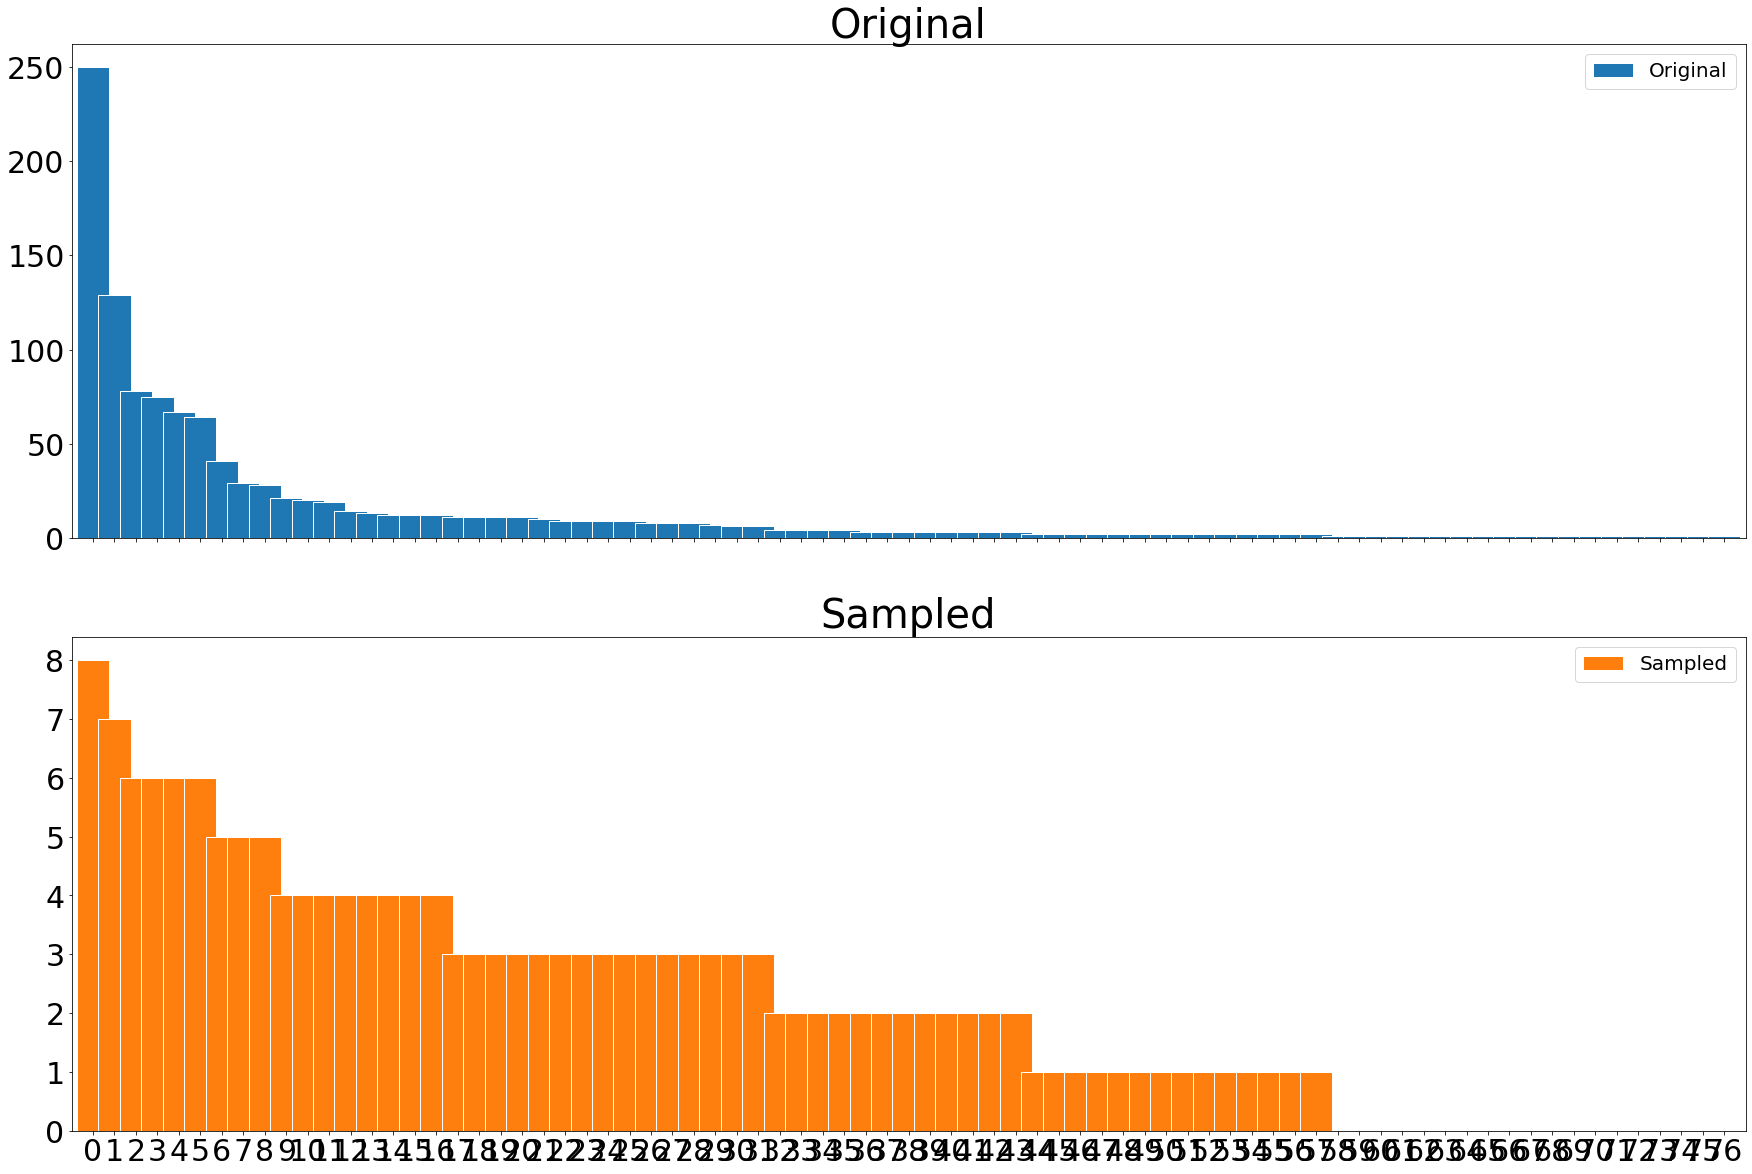

In [63]:
computation_sampling(dataframe_xes_copy, ci, ac, unnecessaries, n = 3)

In [130]:
log_csv_for_final = preprocessing_caseid(dataframe, ci)
    
log_csv = preprocessing_caseid_nan(dataframe, ci)
    
variant_caseid, stat1 = preprocessing_csv(dataframe, ci, ac)

In [131]:
ns_vci, s_vci = filtersingles_mp(variant_caseid)
    
last_activities_raw = get_last_activities(log_csv, ci, unnecessaries)

#extract just the very last row of each cases and separate Categorical Columns (ccols)
last_activities, ccols = preprocessig_df(last_activities_raw, ci)

['concept:name', 'case:concept:name', 'defectType', 'numberRepairs']


In [132]:
last_activities

,concept:name,case:concept:name,defectType,numberRepairs
8,Archive Repair,Case 1,7,0
22,Archive Repair,Case 10,7,2
31,Archive Repair,Case 100,7,0
40,Archive Repair,Case 1000,7,1
48,Test Repair,Case 1001,7,0
...,...,...,...,...
11813,Archive Repair,Case 995,7,0
11822,Archive Repair,Case 996,7,0
11831,Archive Repair,Case 997,7,0
11840,Archive Repair,Case 998,7,0


In [139]:
dfs_variant = []

for i in range(len(ns_vci)):
            
    dfs_variant += splitdf(last_activities, ns_vci[i], ci)

In [140]:
dfs_variant

[     concept:name case:concept:name defectType numberRepairs
 223   Test Repair         Case 1018          7             0
 322   Test Repair         Case 1028          7             0
 429   Test Repair         Case 1039          7             0
 488   Test Repair         Case 1044          7             0
 525   Test Repair         Case 1048          7             0
 616   Test Repair         Case 1057          7             0
 859   Test Repair         Case 1080          7             0
 1077  Test Repair         Case 1107          7             0,
          concept:name case:concept:name defectType numberRepairs
 136    Archive Repair          Case 101          7             0
 1086   Archive Repair          Case 111          7             0
 1250   Archive Repair          Case 119          7             0
 1591   Archive Repair          Case 145          7             0
 1609   Archive Repair          Case 147          7             0
 ...               ...               ...     

In [141]:
dfs_variant_encoded = map_one_hotenc(dfs_variant, ccols)

/Users/thetruetae/anaconda3/envs/env-IDS2020/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [142]:
dfs_variant_encoded

[     case:concept:name
 223          Case 1018
 322          Case 1028
 429          Case 1039
 488          Case 1044
 525          Case 1048
 616          Case 1057
 859          Case 1080
 1077         Case 1107,
       case:concept:name
 136            Case 101
 1086           Case 111
 1250           Case 119
 1591           Case 145
 1609           Case 147
 ...                 ...
 10774          Case 908
 10945          Case 920
 11095          Case 934
 11204          Case 944
 11689          Case 985
 
 [78 rows x 1 columns],
      case:concept:name
 1683          Case 152
 2602          Case 225
 3820          Case 330,
      case:concept:name
 5232          Case 446
 8266            Case 7
 9182          Case 775,
     case:concept:name
 101         Case 1007
 347         Case 1030
 363         Case 1032
 587         Case 1054,
       case:concept:name
 2423           Case 210
 2482           Case 216
 3228           Case 279
 3907           Case 338
 4184           Case 3

In [143]:
euclidean_dist = euclidean_distance_list(dfs_variant_encoded, ci)

In [146]:
euclidean_dist[0]

case:concept:name
Case 1018    4.5
Case 1028    4.5
Case 1039    4.5
Case 1044    4.5
Case 1048    4.5
Case 1057    4.5
Case 1080    4.5
Case 1107    4.5
Name: dist_order, dtype: float64

In [149]:
logarithmic_selection_map(euclidean_dist)

[[case:concept:name
  Case 1018    4.5
  Case 1028    4.5
  Case 1039    4.5
  Case 1044    4.5
  Case 1048    4.5
  Case 1057    4.5
  Case 1080    4.5
  Case 1107    4.5
  Name: dist_order, dtype: float64,
  3],
 [case:concept:name
  Case 101    39.5
  Case 686    39.5
  Case 679    39.5
  Case 677    39.5
  Case 666    39.5
              ... 
  Case 30     39.5
  Case 298    39.5
  Case 297    39.5
  Case 337    39.5
  Case 985    39.5
  Name: dist_order, Length: 78, dtype: float64,
  6],
 [case:concept:name
  Case 152    2.0
  Case 225    2.0
  Case 330    2.0
  Name: dist_order, dtype: float64,
  2],
 [case:concept:name
  Case 446    2.0
  Case 7      2.0
  Case 775    2.0
  Name: dist_order, dtype: float64,
  2],
 [case:concept:name
  Case 1007    2.5
  Case 1030    2.5
  Case 1032    2.5
  Case 1054    2.5
  Name: dist_order, dtype: float64,
  2],
 [case:concept:name
  Case 210    14.5
  Case 978    14.5
  Case 97     14.5
  Case 95     14.5
  Case 94     14.5
  Case 923    14.5